<a href="https://colab.research.google.com/github/JMindpalace/codestate_section3_project/blob/main/1.%20%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%85%8B%20%EC%84%A4%EB%AA%85(~SQLite).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. 데이터셋: 공공데이터포털 홈페이지 > 국민건강보험_건강검진정보 데이터
국민건강보험공단에서 제공한 '16~20년도(5년간) 한국인의 건강 검진 정보'를 분석 대상으로 합니다.<br>

20년 데이터: https://www.data.go.kr/data/15007122/fileData.do#tab-layer-file <br>

하단 '주기성 과거 데이터'에서 추가적 4년 데이터 확보<br>
19년 데이터: 국민건강보험공단_건강검진정보_20191231<br>
18년 데이터: 건강검진정보(2018)_20191231<br>
17년 데이터: 건강검진정보(2017)<br>
16년 데이터: 건강검진정보(2016)<br>

# 0. 데이터 설명(국민건강보험공단의 사용자 메뉴얼도 포함하여 설명함)
(https://www.data.go.kr/data/15007122/fileData.do#layer_data_infomation)
> 데이터 사이즈 : (1,000,000, 31) - (국민건강보험가입자 중 100만 명 무작위 선별)<br>
> 데이터 기간 : 16~20년도 자료(매년 12월에 2년 전 자료 추가 방식으로 22년 기준 20년도가 최신 자료)

Feature(총 31개의 열이 있지만 분석에 필요한 15열만 작성함)<BR>
< 검진자 기본 정보 >
  - 기준년도: 연도별 증가/차이점 등을 파악하기 위하여 1차적 키값과 같이 사용함
  - 성별코드: 1은 남자 / 2는 여자(검진마다 정상 범위가 다름)
  - 연령대 코드(5세단위): '40~44세를 그룹9'로 이후 5세마다 +1로 하여 10개 그룹

< 검진 결과 & 기저 원인 ><br>
{ 생활습관 - 운동 }
  - 신장(5Cm 단위): 키는 내림으로 100~104의 5cm 구간을 100으로 통일
  - 체중(5Kg 단위): 체중 또한 내림으로 70~74의 5kg 구간을 70으로 통일
  - 허리둘레(cm 단위): 남성 90, 여성 85 이상이면 복부비만<br>

{ 장기 질환 판단 > 신장 > 혈압 조절 호르몬 분비 }
  - 요단백: 소변에 단백질이 섞인 여부
  - 혈청크레아티닌: 몸 속 노폐물 수치(1.7이상 위험군)<br>

{ 장기 질환 판단 > 간 > 콜레스테롤 조절 }
  - (혈청지오티)AST: 세포 손상 농도(40 이상 위험)
  - (혈청지오티)ALT: 비만 정도에 민감한 반응(40 이상 위험)
  - 감마 지티피: 음주에 민감한 반응(남성 63, 여성 35 이상 위험)

< Target Data ><br>
{ 고혈압 Target }
- 수축기 혈압(mmHG): 검진자의 최고 혈압
- 이완기 혈압(mmHG): 검진자의 최저 혈압<br>

{ 당뇨 Target }
- 식전혈당(공복혈당): 혈액 100ML당 포도당 수치(126이상 당뇨병)<br>

{ 고지혈증 Target }
  - 총 콜레스테롤: 중성지방 + HDL 콜레스테롤 + LDL 콜레스테롤의 총 합



---



---



# 1. Feature drop 근거
1. 가입자 일련번호: 연도별 index역할이나 무작위 선발로 같은 사람이 아니기에 Drop<br>
2. 시도코드: 지역적 조건에 따른 질병 해석은 오해의 소지가 있을 수 있음<br>
3. 시력(좌,우): 시력 감소의 시기는 찾을 수 있지만 원인에 대한 해석이 어려움<br>
4. 청력(좌,우): 결과에 대한 활용 도메인 부족<br>
5. (트리글리세라이드+HDL+LDL): 3가지 콜레스테롤의 합이 총 콜레스테롤이기에 drop<br>
6. 혈색소: 빈혈과 연관있지만 현재 타겟이 3개이기에 지금은 drop<br>
7. 구강검진 수검여부, 치아우식증유무, 치석 : 치아는 양치를 통해 관리 가능<br>
8. 결손치유무, 치아마모증유무, 제3대구치(사랑니)이상: 13년까지만 측정되어 모두 null(20년부터는 제외됨)<br>
9. 데이터 공개일자: 공개일자가 같이게, 기준년도로 대체 drop
10. 흡연상태/음주여부 : 문진으로 진행한 답변이고, 답의 구분이 모호하여 사용에 어려움

# 1. Row drop 근거

0. 의료적 수치의 임의적 변경은 불가능함
   > 해당 데이터셋의 경우 개개인의 검진을 통해 획득한 데이터<br>
   > 따라서 평균 등의 임의적 변경은 오염된 데이터셋이 되기에 drop을 목표로 함



---



---



# 1차 데이터셋 전처리: Colab
> 사유: 필요한 행열만을 병합하여 저장한 파일을 만듬

1. 파이썬 API로 DB에 연결했으나 다음 처리가 힘들어 대체함
> 다중 결측치 처리, 열 이름 변경(연도별 띄어쓰기가 다름), 필요 없는 열 삭제, 타입 정리

2. 5년치 데이터를 기준년도로 구분하여 병합하여 저장한 파일이 필요함

In [ ]:
import csv
import pandas as pd
import numpy as np

af = pd.read_csv('국민건강보험공단_건강검진정보_16.csv', encoding='cp949') # 16년 : 994,110
bf = pd.read_csv('국민건강보험공단_건강검진정보_17.csv', encoding='cp949') # 17년 : 995,102
cf = pd.read_csv('국민건강보험공단_건강검진정보_18.csv', encoding='cp949') # 18년 : 331,149

ef = pd.read_csv('국민건강보험공단_건강검진정보_20.CSV', encoding='cp949') # 20년 : 400,207

# 19년도 데이터는 Error tokenizing data. C error 에러로 별도 처리

f = open('국민건강보험공단_건강검진정보_19.csv', encoding='cp949') # 19년 : 353,164
reader, csv_list = csv.reader(f), []

for i in reader:
  csv_list.append(i)
f.close()

df = pd.DataFrame(csv_list)
df.columns = df.loc[0]
df = df[1:]
df = df.iloc[ : , :34 ]
df = df.replace('', np.nan, regex=True)

# 16년부터 20년까지 모두 진행(15행이 되게 drop) + 결측치 drop + 열 이름 정리
drop_col = ['가입자일련번호','시도코드','시력(좌)','시력(우)','청력(좌)','청력(우)','트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤',
            '혈색소','구강검진수검여부','치아우식증유무', '결손치유무', '치아마모증유무', '제3대구치(사랑니)이상', '치석','데이터공개일자', '흡연상태', '음주여부']
af = af.drop( drop_col, axis=1 )
af = af.dropna()
af.columns = ['기준년도', '성별', '연령대', '신장', '체중', '허리둘레', '최고혈압', '최저혈압', '공복혈당', '총콜레스테롤', '요단백', '혈청크레아티닌', 'AST', 'ALT', '감마GTP']

# 모든 데이터 병합
merge_inner = pd.concat([af, bf])

# 병합으로 object형이기에 데이터 타입 변경
merge_inner['기준년도'] = merge_inner['기준년도'].astype(int)
merge_inner['성별'] = merge_inner['성별'].astype(int)
merge_inner['연령대'] = merge_inner['연령대'].astype(int)
merge_inner['신장'] = merge_inner['신장'].astype(int)
merge_inner['체중'] = merge_inner['체중'].astype(int)
merge_inner['허리둘레'] = merge_inner['허리둘레'].astype(float)
merge_inner['최고혈압'] = merge_inner['최고혈압'].astype(int)
merge_inner['최저혈압'] = merge_inner['최저혈압'].astype(int)
merge_inner['공복혈당'] = merge_inner['공복혈당'].astype(int)
merge_inner['총콜레스테롤'] = merge_inner['총콜레스테롤'].astype(int)
merge_inner['요단백'] = merge_inner['요단백'].astype(int)
merge_inner['혈청크레아티닌'] = merge_inner['혈청크레아티닌'].astype(float)
merge_inner['AST'] = merge_inner['AST'].astype(int)
merge_inner['ALT'] = merge_inner['ALT'].astype(int)
merge_inner['감마GTP'] = merge_inner['감마GTP'].astype(int)

# 연령대 수정 및 BMI열 추가
merge_inner['연령대'] = merge_inner['연령대'].replace( { 5:20, 6:25, 7:30, 8:35, 9:40, 10:45, 11:50, 12:55, 13:60, 14:65, 15:70, 16:75, 17:80, 18:80 } )
merge_inner['BMI'] = round( merge_inner['체중'] / (merge_inner['신장']*merge_inner['신장']) * 10000 , 2)

# CSV파일 저장
merge_inner.to_csv('3백만_5년치_검진정보(3,073,732).csv', index=False)

# SQLite
> 필요 전처리: CSV파일을 'CSV UTF-8(쉼표로 분리)'파일로 변경이 필요함<BR>
(근거: 첫 행의 한글이 모두 깨지는 현상 발생을 방지하고자 파일 확장자 변경)

> 전처리 과정 중 DB의 장점 발견 - 속도
1. CSV파일을 엑셀로 여는 과정에서 1분 10초, 1분 15초 등 1분 이상에 걸려 겨우 파일을 열었음
2. 하지만 SQLite로는 최대 20초로 데이터 확인 가능

> 관리의 장점
1. 하나의 DB파일로 5개의 CSV파일을 보관하여 관리 가능
2. 특히 하나하나 열던 CSV파일을 한 번에 확인 가능

## SQLite - CSV파일 추가
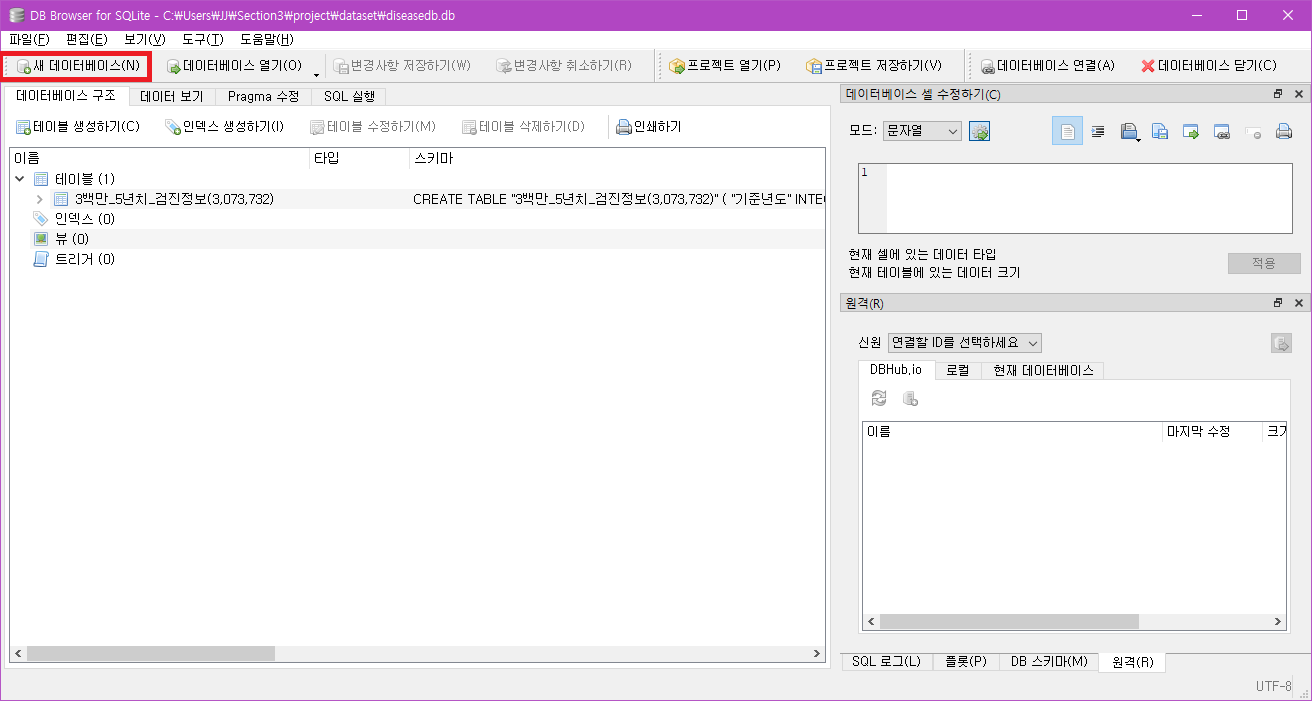

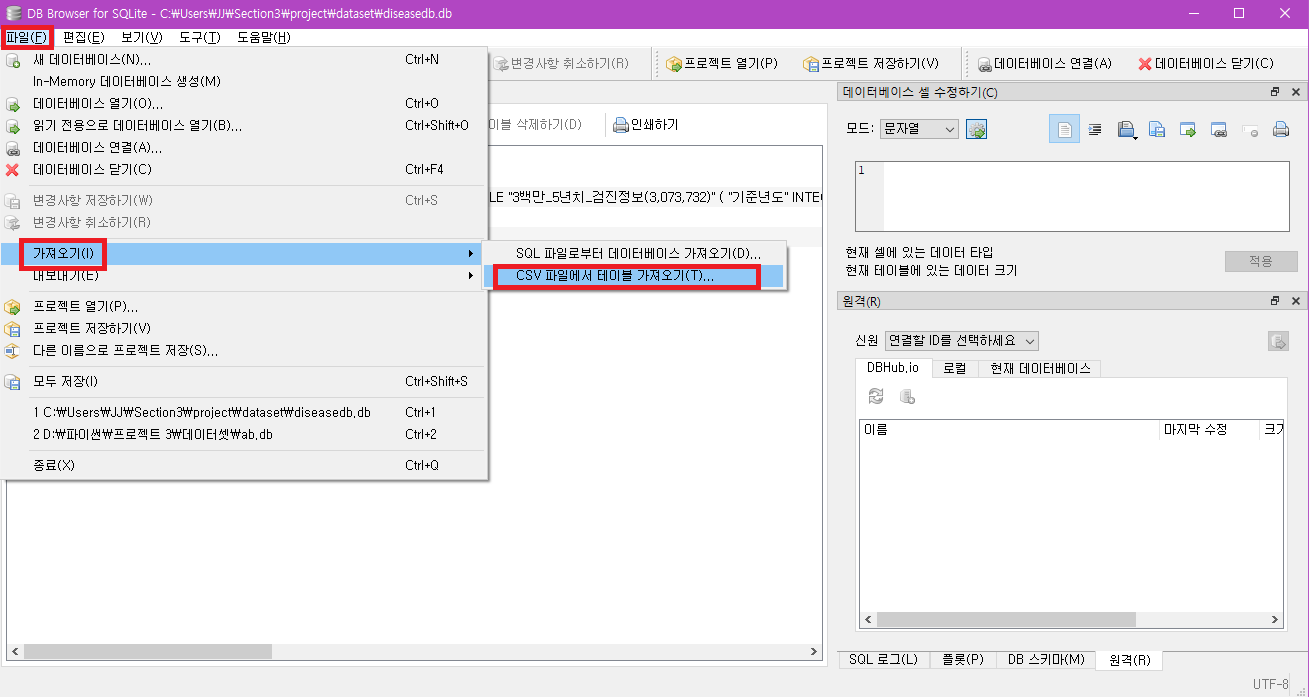

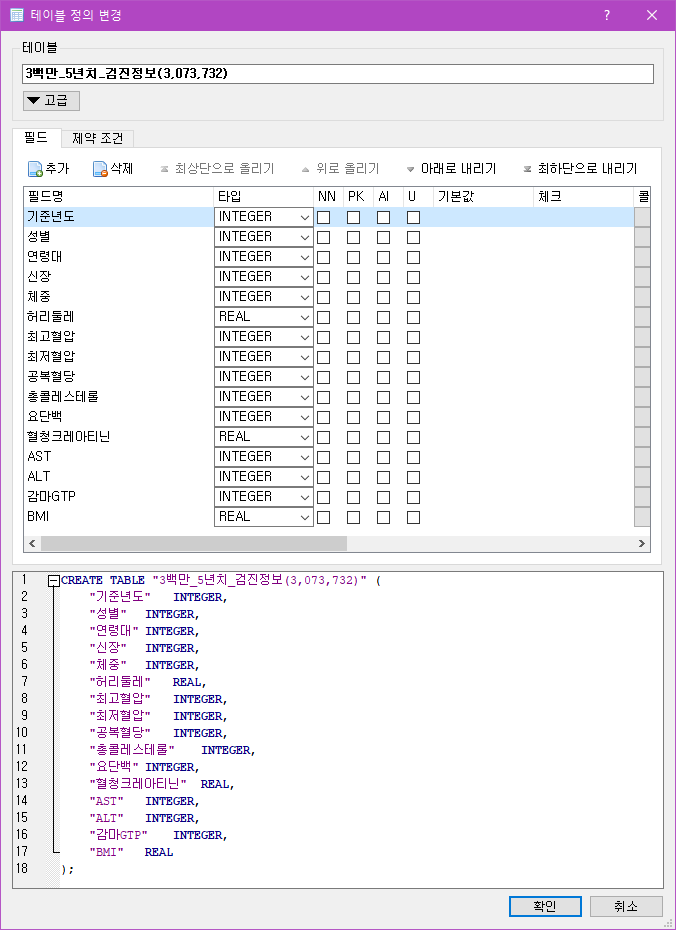

In [ ]:
# 파이썬 API로 DB 연결

import sqlite3

conn = sqlite3.connect('./diseasedb.db')
cur = conn.cursor()

query = cur.execute('SELECT * FROM basic_table') # 테이블 내용 불러오기
cols = [column[0] for column in query.description] # 칼럼명 가져오기
df = pd.DataFrame.from_records(data=query.fetchall(), columns=cols) # 데이터프레임화

conn.close() # DB 닫기